In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras.preprocessing import image


Model = tf.keras.models.Model
VGG19 = tf.keras.applications.VGG19
ResNet50 = tf.keras.applications.ResNet50

GlobalAveragePooling2D = tf.keras.layers.GlobalAveragePooling2D
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

In [ ]:
ON_COLAB = True

In [ ]:
if ON_COLAB:
    # mound google drive
    from google.colab import drive

    DRIVE_ROOT = "/content/drive"
    DRIVE_DATA_ROOT = os.path.join(DRIVE_ROOT, "My Drive/CP322")
    DRIVE_TRAINING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Training")
    DRIVE_TESTING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Testing")

    drive.mount(DRIVE_ROOT)

    MODEL_SAVE_PATH = os.path.join(DRIVE_DATA_ROOT)
    
else:
    DRIVE_ROOT = "../"
    DRIVE_DATA_ROOT = os.path.join(DRIVE_ROOT, "data/raw")
    DRIVE_TRAINING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Training")
    DRIVE_TESTING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Testing")
    
    MODEL_SAVE_PATH = os.path.join(DRIVE_ROOT, 'trained-models')

print(DRIVE_ROOT)
print(DRIVE_DATA_ROOT)
print(DRIVE_TRAINING_FOLDER)
print(DRIVE_TESTING_FOLDER)
print(MODEL_SAVE_PATH)

Mounted at /content/drive
/content/drive
/content/drive/My Drive/CP322
/content/drive/My Drive/CP322/Training
/content/drive/My Drive/CP322/Testing
/content/drive/My Drive/CP322


In [ ]:
def preprocess_image(img_path, target_size=(224, 224)):
  assert type(target_size) == tuple, "Target size must be of type tuple"
  img = tf.io.read_file(img_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, target_size)
  img /= 255.0 # normalize
  return img

def load_data(target="train", limit=200, randomize=True):
  # for now the method only loads all the data as yes or no

  X = []
  Y = []
  # load images that don't have brain tumour
  if target == "train":
    data_dir = DRIVE_TRAINING_FOLDER
  else:
    data_dir = DRIVE_TESTING_FOLDER
  
  no_dir = os.path.join(data_dir, "no")
  files = os.listdir(no_dir)
  if randomize:
    np.random.shuffle(files)
  count = 0
  for img_name in os.listdir(no_dir):
    if count == limit:
      break
    img = preprocess_image(os.path.join(no_dir, img_name))
    X.append(img)
    Y.append(0)
    count += 1
  
  # load images that have brain tumour
  labels = ['pituitary', 'meningioma', 'glioma']
  limit_per_type = [limit // len(labels) if i != len(labels) - 1 else limit // len(labels) + limit % len(labels) for i in range(len(labels))]
  for i in range(len(labels)):
    limit = limit_per_type[i]
    label = labels[i]
    count = 0
    folder = os.path.join(data_dir, label)
    imgs = os.listdir(folder)
    if randomize:
      np.random.shuffle(imgs)
    for img_name in imgs:
      if count == limit:
        break
      img = preprocess_image(os.path.join(folder, img_name))
      X.append(img)
      Y.append(1)
      count += 1
  
  X = np.array(X)
  Y = np.array(Y)

  return X, Y

In [ ]:
class DetectorModelBaseVGG19:
    def __init__(self, weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=["no", "yes"]):
        self.classes = [cl for cl in classes]
        self._build(weights, include_top, input_shape)

    def _build(self, weights, include_top, input_shape):
        vgg19 = VGG19(
            weights=weights, include_top=include_top, input_shape=input_shape)
        for layer in vgg19.layers:
            layer.trainable = False

        x = vgg19.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.5)(x)

        predictions = Dense(2, activation='softmax')(x)

        self.model = Model(inputs=vgg19.input, outputs=predictions)

    def fit(self, train_X, train_Y, test_X, test_Y, batch_size=32, epochs=30, verbose=1):
        train_Y = to_categorical(train_Y, num_classes=len(self.classes))
        test_Y = to_categorical(test_Y, num_classes=len(self.classes))
        history = self.model.fit(
            train_X,
            train_Y,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            validation_data=(test_X, test_Y))
        self.history = history

        return history

    def compile(self, optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]):
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )

    def predict(self, X):
        return self.model.predict(X)

    def compute_roc_curve(self, test_X, test_Y):
        y_true = np.argmax(to_categorical(test_Y, num_classes=2), axis=1)
        y_pred = self.predict(test_X)
        y_pred_pos = y_pred[:, 1]

        fpr, tpr, _ = roc_curve(y_true, y_pred_pos)
        roc_auc = auc(fpr, tpr)

        return fpr, tpr, roc_auc

    def plot_roc_curve(self, test_X, test_Y):
        fpr, tpr, roc_auc = self.compute_roc_curve(test_X, test_Y)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    def plot_accuracy(self):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'],
                 label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    def plot_confusion_matrix(self, test_X, test_Y):
        y_pred = self.predict(test_X)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(to_categorical(test_Y), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False, linewidth=0.5)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def load(self, path):
        self.model = load_model(path)

    def save(self, save_path):
        self.model.save(save_path)

    def score(self, test_X, test_Y, verbose=0):
        test_Y = to_categorical(test_Y, num_classes=len(self.classes))
        return self.model.evaluate(test_X, test_Y, verbose=verbose)

    def grid_search(self, param_grid, train_X, train_Y, test_X, test_Y, epochs=30, verbose=1):
        best_model = None
        best_score = -np.inf
        best_params = None
        best_history = None

        param_combinations = ParameterGrid(param_grid)

        for params in param_combinations:
            print(f"Training with parameters: {params}")

            # Reset model
            self.build()
            self.compile(optimizer=params['optimizer'],
                         loss=params['loss'], metrics=["accuracy"])

            history = self.fit(train_X, train_Y, test_X, test_Y,
                               batch_size=params['batch_size'], epochs=params['epochs'], verbose=verbose)

            score = self.score(test_X, test_Y)

            if score[1] > best_score:
                best_model = self.model
                best_score = score[1]
                best_params = params
                best_history = history

            print(f"Accuracy: {score[1]}")

        self.model = best_model
        self.history = best_history

        print(f"Best parameters: {best_params}")
        print(f"Best accuracy: {best_score}")

        return best_history, best_params

In [ ]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("CUDA is available. GPU:", tf.config.list_physical_devices('GPU')[0])
else:
    print("CUDA is not available.")

CUDA is available. GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
random_seed = 42
X, Y = load_data(target='train', limit=600)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=random_seed)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((960, 224, 224, 3), (240, 224, 224, 3), (960,), (240,))

80134624/80134624 [==============================] - 1s 0us/step
loss: 0.2568266689777374
accuracy: 0.9363183975219727


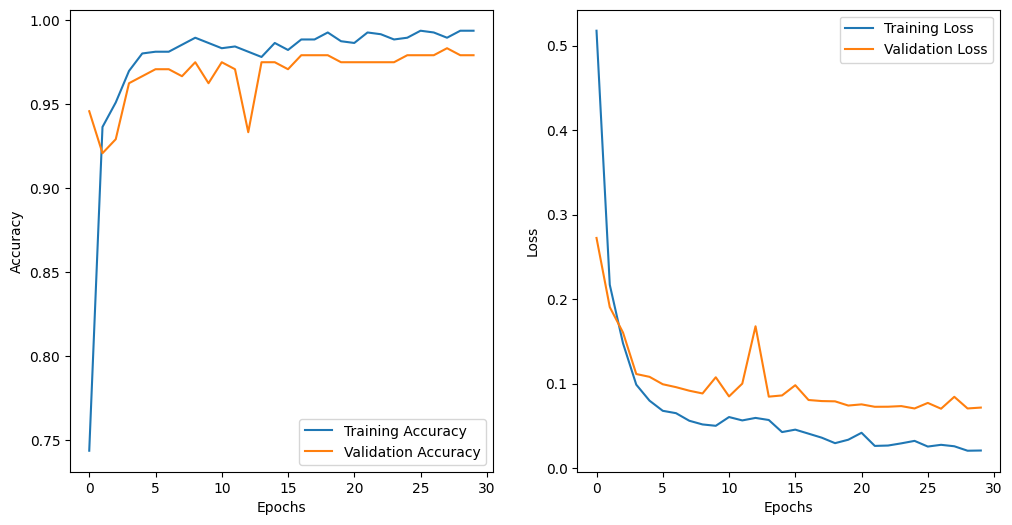

In [ ]:
best_vgg_model = DetectorModelBaseVGG19()

best_vgg_model.compile(optimizer='adam', loss='binary_crossentropy')

best_vgg_history = best_vgg_model.fit(train_X, train_Y, test_X, test_Y, batch_size=32, epochs=30, verbose=0)

test_X, test_Y = load_data(target="test", limit=600)

score = best_vgg_model.score(test_X, test_Y)

print("loss:", score[0])
print("accuracy:", score[1])

best_vgg_model.plot_accuracy()

In [ ]:
best_vgg_model.save(os.path.join(MODEL_SAVE_PATH, 'vgg19.h5'))

In [ ]:
model = DetectorModelBaseVGG19()
model.load(os.path.join(MODEL_SAVE_PATH, 'vgg19.h5'))

32/32 [==============================] - 5s 151ms/step


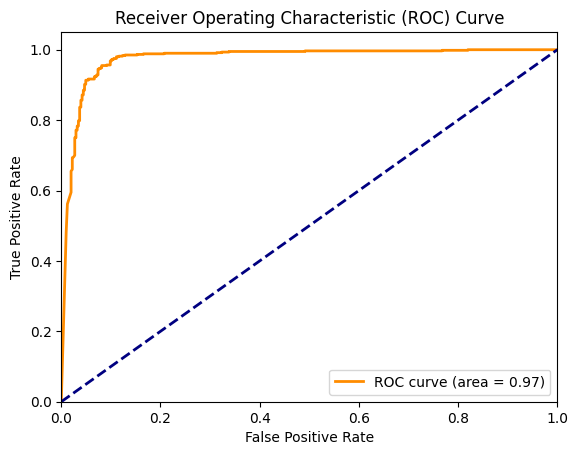

In [ ]:
model.plot_roc_curve(test_X, test_Y)

32/32 [==============================] - 5s 152ms/step


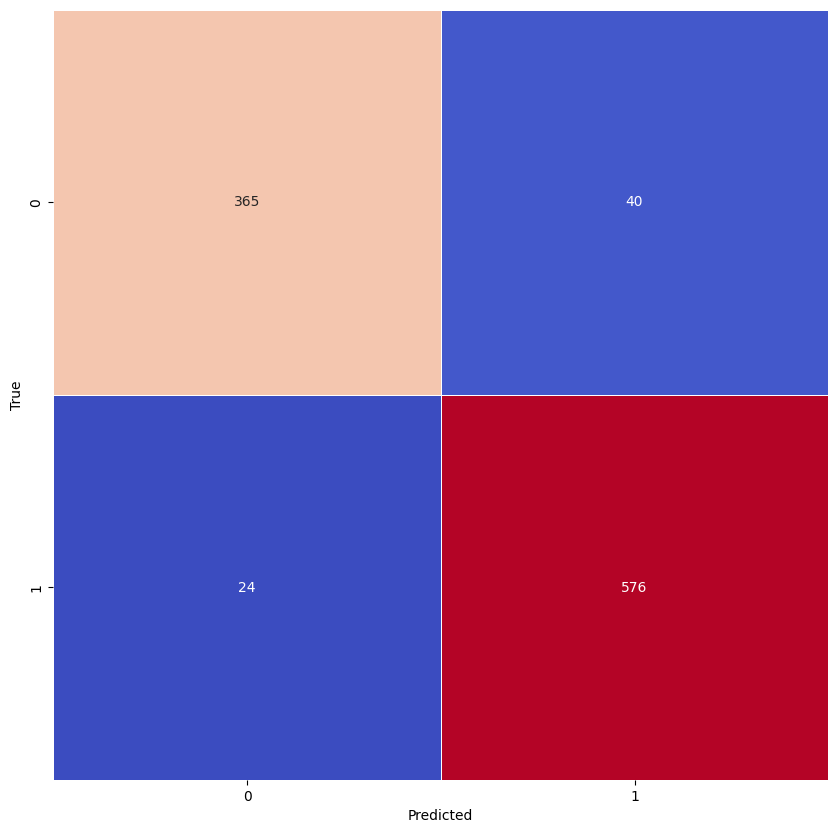

In [ ]:
model.plot_confusion_matrix(test_X, test_Y)

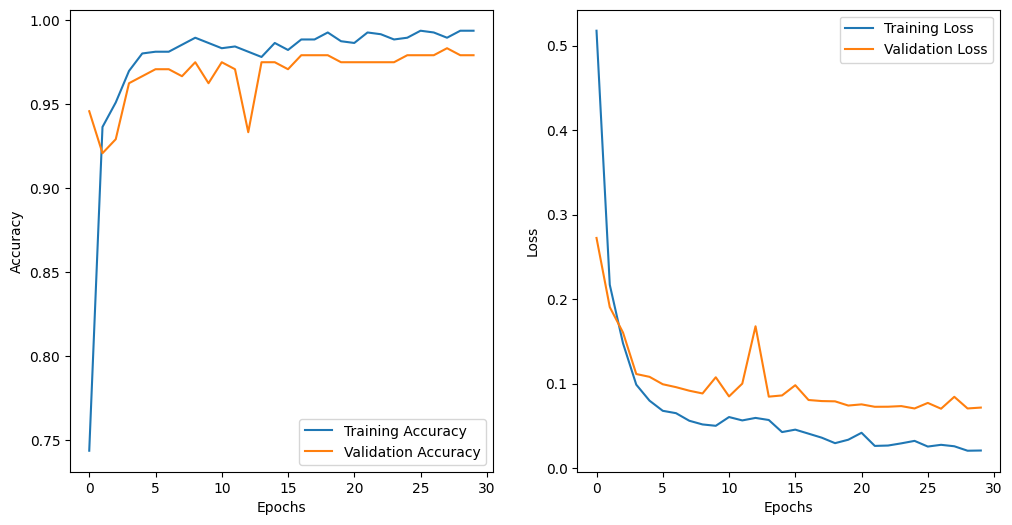

In [ ]:
model.history = best_vgg_history
model.plot_accuracy()